<a href="https://colab.research.google.com/github/ritwikranjan/mlProject/blob/master/Emoji_Prediction_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Importing all the Libraries


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
import re

## Importing data using Pandas


In [6]:
df = pd.read_csv('/content/data/Train.csv')
df = df.drop(columns=['Unnamed: 0'], )

In [7]:
df.head()

,TEXT,Label
0,Vacation wasted ! #vacation2017 #photobomb #ti...,0
1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",1
2,Been friends since 7th grade. Look at us now w...,2
3,This is what it looks like when someone loves ...,3
4,RT @user this white family was invited to a Bl...,3


## Pre-Processing using NLTK and re. 

* Stopword removal using NLTK                                     
* Tokenisation using re
* Removing words starting with #

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
corpus = list()
sw = set(stopwords.words('english'))

for i in range(70000):
    text = df['TEXT'][i]
    text = text.lower()
    text = re.findall('[a-z#]+', text)
    text = [word for word in text if word[0] != '#' and word not in sw]
    text = ' '.join(text)
    corpus.append(text)

### Making a dataframe using the pandas library


In [11]:
refined_df = pd.DataFrame(corpus)
refined_df = refined_df.join(df['Label'])
refined_df.columns = ['text', 'emoji_label']
refined_df = refined_df[refined_df['text'].map(len) > 0]

In [12]:
refined_df.head()

,text,emoji_label
0,vacation wasted port,0
1,oh wynwood funny user wynwood,1
2,friends since th grade look us following dream...,2
3,looks like someone loves unconditionally oh pu...,3
4,rt user white family invited black barbecue ne...,3


## Exploratory Data Analysis using matplotlib and seaborn

* using numpy to make a frequency table for every emoji
* making a bar plot using seaborn


In [13]:
label_array = np.array(refined_df['emoji_label'])
(emojis, counts) = np.unique(label_array, return_counts=True)

In [14]:
print(emojis)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 1556  2592  7071  6836  1876  1975  2083  4361  1992 15060  1721  2429
  1907  3248  2340  3843  2826  2751  1721  1742]


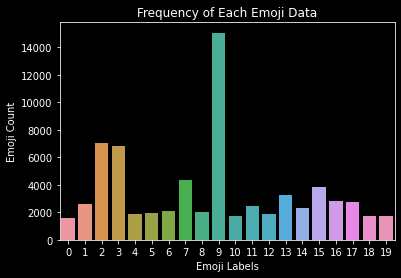

In [15]:
plt.style.use('dark_background')
sns.barplot(x = emojis, y = counts)
plt.xlabel(xlabel='Emoji Labels')
plt.ylabel(ylabel='Emoji Count')
plt.title('Frequency of Each Emoji Data')
plt.show()

> We can obseve that the distribution is not good so we will oversample the data at a later phase


# Transfer Learning and Over-Sampling

## Importing glove which is comprised of 6 Billion words with 50 dimentions

In [16]:
f = open("/content/data/glove.6B.50d.txt", encoding='utf8')

embedding_index = dict()

for line in f:
    values = line.split()
    word = values[0]
    emb = np.array(values[1:], dtype ='float')
    embedding_index[word] = emb
    

In [17]:
print(embedding_index['apple'])

[ 0.52042  -0.8314    0.49961   1.2893    0.1151    0.057521 -1.3753
 -0.97313   0.18346   0.47672  -0.15112   0.35532   0.25912  -0.77857
  0.52181   0.47695  -1.4251    0.858     0.59821  -1.0903    0.33574
 -0.60891   0.41742   0.21569  -0.07417  -0.5822   -0.4502    0.17253
  0.16448  -0.38413   2.3283   -0.66682  -0.58181   0.74389   0.095015
 -0.47865  -0.84591   0.38704   0.23693  -1.5523    0.64802  -0.16521
 -1.4719   -0.16224   0.79857   0.97391   0.40027  -0.21912  -0.30938
  0.26581 ]


> You can clearly see that each word is represented as a vector of 50 numerical values


### Now we will define a function *get_embedding_output*  

> It will take a text dataframe as an input and then convert each word into a vector of 50 elements.

> As we have removed a lot of words such as stop words we will be use a maximum of 12 words per tweet.



In [20]:
def get_embedding_output(X):
    maxLen = 12
    embedding_output = np.zeros((len(X), maxLen, 50))

    for ix in range(X.shape[0]):
        my_example = X[ix].split()
       
        for ij in range(len(my_example)):
            if (embedding_index.get(my_example[ij].lower()) is not None) and (ij < maxLen):
                embedding_output[ix][ij] = embedding_index[my_example[ij].lower()]

    return embedding_output


In [30]:
x_train = refined_df['text'].values
y_train = refined_df['emoji_label'].values
x_train_embed = get_embedding_output(x_train)

In [31]:
print(x_train_embed[0])

[[ 1.2875    1.2586   -0.71297  -0.15497  -0.61965  -0.80052  -2.0029
   0.41959  -0.075328 -0.21366  -0.84603  -0.082605  0.99821   0.11348
   1.6989    0.65965  -0.32471  -0.24805  -0.047889  0.081395  0.48102
   0.51665  -0.5788    0.74126   0.31082  -0.67281  -0.25039   0.22736
   1.1558    0.54096   1.5812    0.91512  -0.88902   0.52964   0.534
   0.1331   -0.51461   0.36751  -0.14438  -0.43314  -0.52991   0.48018
   0.49344   0.46789  -0.46684  -0.39633   0.1686   -0.23279   0.2212
   0.72042 ]
 [ 0.18103  -0.40867   0.43368  -0.30662   0.23923  -0.088941 -0.18667
   1.0391   -0.071017  1.0576   -0.39      0.051926 -0.47777   0.054245
   0.56796  -0.76576   0.90016  -0.29673  -0.14303  -0.37184  -0.25412
   0.044725  0.24972  -0.58401   0.66839  -0.46125   0.40017   0.12867
   0.57054  -0.3514    1.3048    1.059     0.39403  -0.10169  -0.48836
   0.7662   -0.11982   1.27      0.33597  -0.69918   0.16059   0.038067
  -0.070814  0.15741  -0.58301   0.272    -0.49875   0.29675   0.1

> Now each tweet will be an numpy array of 12 x 50

### Converting emoji_label to One Hot Vector

In [32]:
from keras.utils import to_categorical

y_train_ohv = to_categorical(y_train)

In [33]:
print(y_train[8])
print(y_train_ohv[8])

2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Oversampling using SMOTE


In [34]:
x_train_embed.shape

(69930, 12, 50)

In [ ]:
from imblearn.over_sampling import SMOTE

x_train_embed = x_train_embed.reshape(-1, 600)

oversample = SMOTE()
x, y = oversample.fit_resample(x_train_embed, y_train)

In [36]:
print(x.shape)

print(y.shape)

(301200, 600)
(301200,)


> Now we will visualize and see if our data is properly sampled or not

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[15060 15060 15060 15060 15060 15060 15060 15060 15060 15060 15060 15060
 15060 15060 15060 15060 15060 15060 15060 15060]


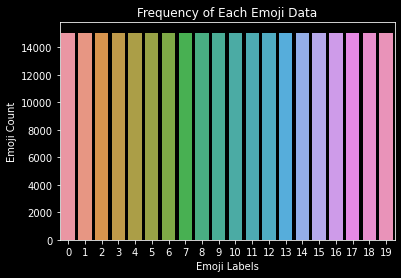

In [40]:
(emojis, counts) = np.unique(y, return_counts=True)

print(emojis)
print(counts)

plt.style.use('dark_background')
sns.barplot(x = emojis, y = counts)
plt.xlabel(xlabel='Emoji Labels')
plt.ylabel(ylabel='Emoji Count')
plt.title('Frequency of Each Emoji Data')
plt.show()

> Now our data is properly sampled. We will reshape our data such that it gets reverted to its original values

In [41]:
x = x.reshape((-1,12,50))

x.shape

(301200, 12, 50)

In [42]:
y = to_categorical(y)

print(y[1])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


> Now our data is properly configured to be fed to a neural Network

## Forming Layers using Keras